In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
palette = sns.color_palette('Paired', 10)
#中文绘图修改
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 数据读取

In [2]:
data_raw=pd.read_csv(r'..\train.csv', parse_dates=["pickup_datetime"],nrows=100000)

In [10]:
data_raw.head()

key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
key                  10000 non-null object
fare_amount          10000 non-null float64
pickup_datetime      10000 non-null datetime64[ns, UTC]
pickup_longitude     10000 non-null float64
pickup_latitude      10000 non-null float64
dropoff_longitude    10000 non-null float64
dropoff_latitude     10000 non-null float64
passenger_count      10000 non-null int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
#描述性统计
data_raw.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  10000.000000      10000.000000     10000.000000       10000.000000   
mean      11.235464        -72.466660        39.920448         -72.474094   
std        9.584258         10.609729         7.318932          10.579732   
min       -2.900000        -74.438233       -74.006893         -74.429332   
25%        6.000000        -73.992058        40.734547         -73.991112   
50%        8.500000        -73.981758        40.752693         -73.980083   
75%       12.500000        -73.966925        40.767694         -73.963504   
max      180.000000         40.766125       401.083332          40.802437   

       dropoff_latitude  passenger_count  
count      10000.000000     10000.000000  
mean          39.893281         1.644700  
std            6.339919         1.271229  
min          -73.994392         0.000000  
25%           40.735230         1.000000  
50%           40.753738         1.000000  
75%           40.768186         2.000000  
max           41.366138         6.000000

In [12]:
data_raw=data_raw.dropna()

In [13]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
key                  100000 non-null object
fare_amount          100000 non-null float64
pickup_datetime      100000 non-null datetime64[ns, UTC]
pickup_longitude     100000 non-null float64
pickup_latitude      100000 non-null float64
dropoff_longitude    100000 non-null float64
dropoff_latitude     100000 non-null float64
passenger_count      100000 non-null int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 6.9+ MB


# 数据探索和清洗

## Y变量探索

根据车费分布图可以看出，车费大多数集中在20元以内；

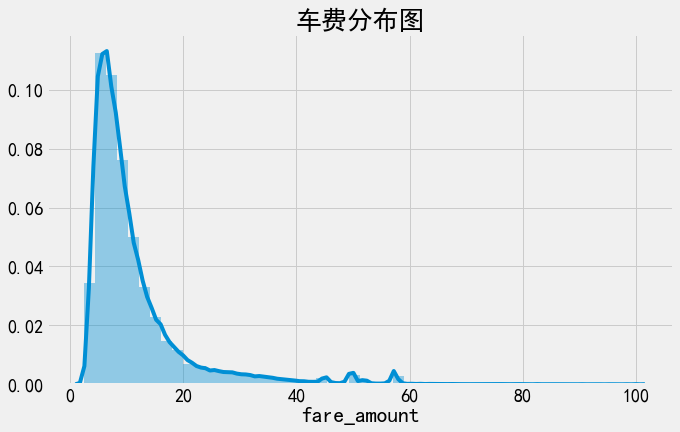

In [41]:
plt.figure(figsize = (10, 6))
sns.distplot(data_raw['fare_amount']);
plt.title('车费分布图');

## Y变量清洗

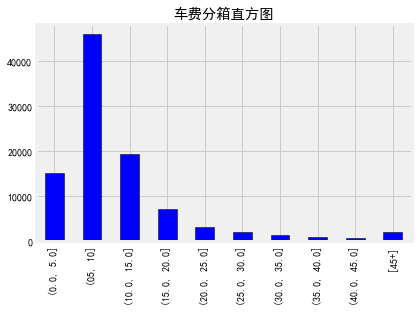

In [47]:
#去除离群点
data_raw = data_raw[data_raw['fare_amount'].between(left = 2.5, right = 100)]
# 数据分箱并转化为字符型
data_raw['fare-bin'] = pd.cut(data_raw['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# 上边界修改
data_raw.loc[data_raw['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

#下边界修改
data_raw.loc[data_raw['fare-bin'] == '(5.0, 10.0]', 'fare-bin'] = '(05, 10]'

# 生成柱状图并按车费排序
data_raw['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title(u'车费分箱直方图');

In [46]:
#累计分布图
def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

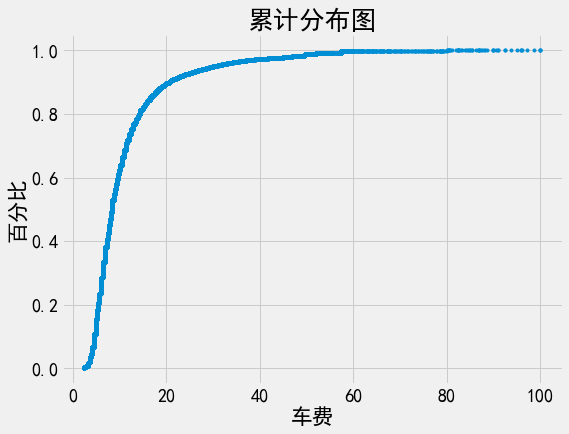

In [50]:
xs, ys = ecdf(data_raw['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')

plt.ylabel('百分比'); plt.title('累计分布图'); plt.xlabel('车费');

## 乘客数量字段（PSAAENGER_COUNT）处理

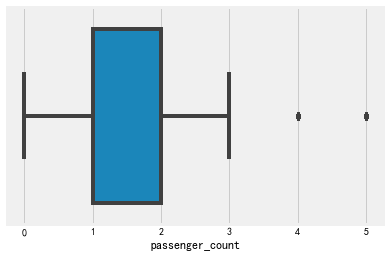

In [45]:
#乘客数量分布，
sns.boxplot(data_raw.iloc[:,7])

In [11]:
#根据出租车负载人数上限，乘客数大于等于6人视为异常应予以删除
data_raw=data_raw[data_raw['passenger_count']<6]

##  经纬度字段处理

In [38]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97960 entries, 0 to 97959
Data columns (total 8 columns):
key                  97960 non-null object
fare_amount          97960 non-null float64
pickup_datetime      97960 non-null datetime64[ns, UTC]
pickup_longitude     97960 non-null float64
pickup_latitude      97960 non-null float64
dropoff_longitude    97960 non-null float64
dropoff_latitude     97960 non-null float64
passenger_count      97960 non-null int32
dtypes: datetime64[ns, UTC](1), float64(5), int32(1), object(1)
memory usage: 5.6+ MB


In [16]:
feature=list(data_raw.columns)

In [18]:
#盖帽法处理极值
data_raw =np.array(data_raw)
for i in range(3,8):
    if type(data_raw[:,i][1])==float:
        a=data_raw[:,i]                #索引data1里的第i列并放入a
        b=np.percentile(a,1)        #计算a里的1%分位数
        c=np.percentile(a,99)      #计算a里的99%分位数
        for j in range(0,len(data_raw[:,0])): #j从0到一列数据的总个数循环
            if a[j]<b:          #如果data1里的第i列里的第j个数小于1%分位数
                a[j]=b          #就把data1里的第i列里的第j个数换成1%分位数
            elif a[j]>c:
                a[j]=c
            else:
                a[j]
data_raw =pd.DataFrame(data_raw)
data_raw.columns=feature
#转换格式

data_raw[['fare_amount', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']] = data_raw[['fare_amount', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].astype(float)

data_raw['pickup_datetime']=pd.to_datetime(data_raw['pickup_datetime'])

data_raw['passenger_count']=data_raw['passenger_count'].astype(int)

In [39]:
#地图
# load image of NYC map
# BB = (-74.5, -72.8, 40.5, 41.8)
# nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.1, -73.7, 40.6, 40.85)
nyc_map_zoom = plt.imread(r'C:\Users\zp&ff\Desktop\nyc_-74.1_-73.7_40.6_40.85.PNG')

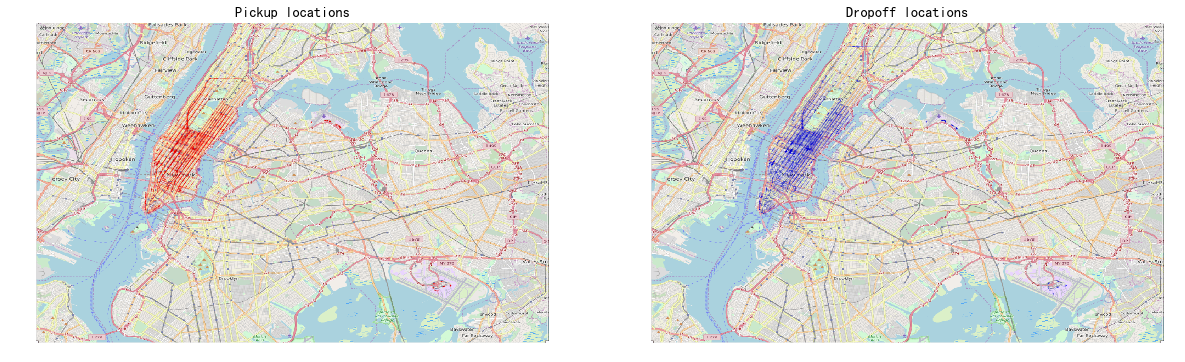

In [42]:

# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(18, 22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
# plot training data on map zoomed in
plot_on_map(data_raw, BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

In [48]:
# Create a color mapping based on fare bins
color_mapping = {fare_bin: palette[i] for i, fare_bin in enumerate(data_raw['fare-bin'].unique())}
color_mapping

{'(0.0, 5.0]': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 '(15.0, 20.0]': (0.12156862745098039,
  0.47058823529411764,
  0.7058823529411765),
 '(05, 10]': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 '(10.0, 15.0]': (0.2, 0.6274509803921569, 0.17254901960784313),
 '(20.0, 25.0]': (0.984313725490196, 0.6039215686274509, 0.6),
 '(30.0, 35.0]': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745),
 '[45+]': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 '(25.0, 30.0]': (1.0, 0.4980392156862745, 0.0),
 '(35.0, 40.0]': (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 '(40.0, 45.0]': (0.41568627450980394,
  0.23921568627450981,
  0.6039215686274509)}

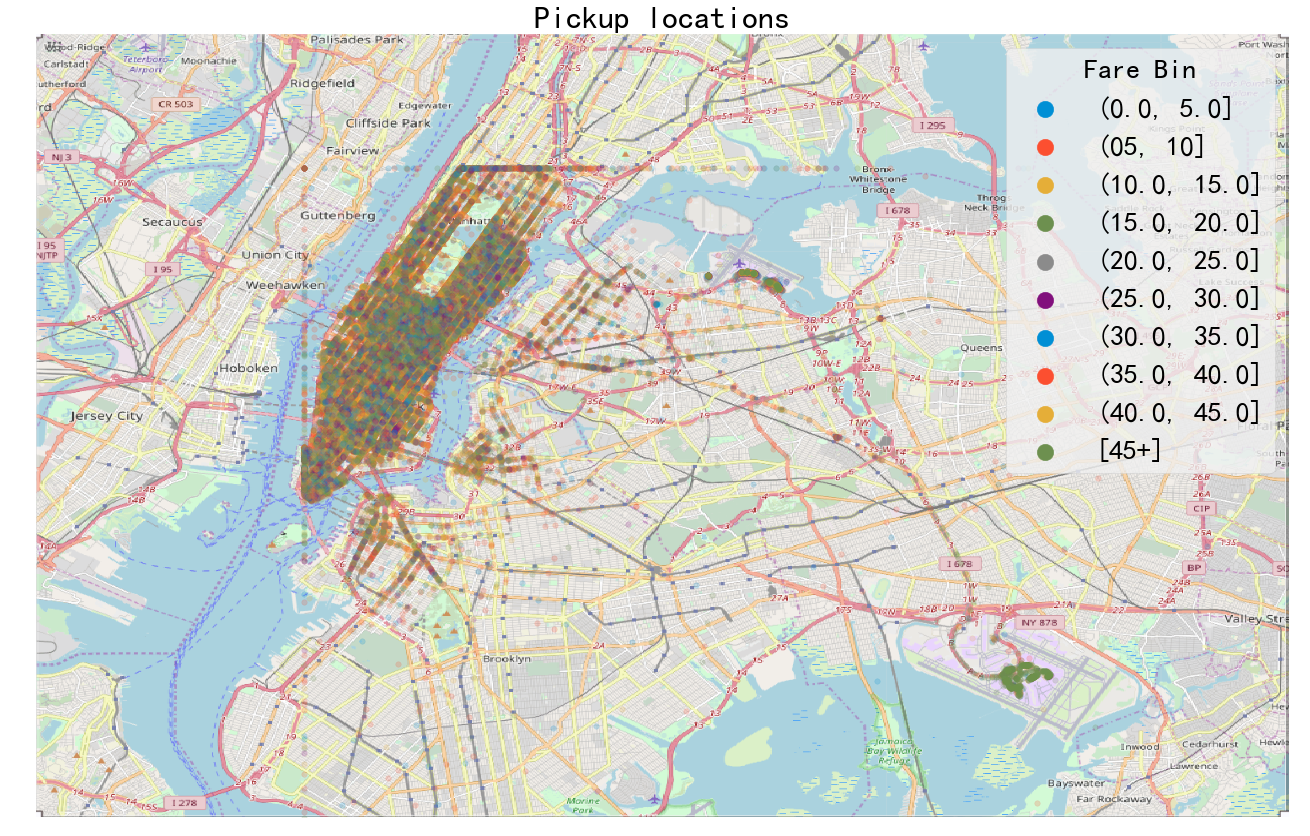

In [50]:
BB = BB_zoom

fig, axs = plt.subplots(1, 1, figsize=(20, 18))

# Plot the pickups
for b, df in data_raw.groupby('fare-bin'):
    # Set the zorder to 1 to plot on top of map
    axs.scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=0.2, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Pickup locations', size = 32)
    axs.axis('off')
    
# Legend
leg = axs.legend(fontsize = 28, markerscale = 3)

# Adjust alpha of legend markers
for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Fare Bin', prop = {'size': 28})

# Show map in background (zorder = 0)
axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

In [4]:

# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread(r'C:\Users\zp&ff\Desktop\nyc_-74.5_-72.8_40.5_41.8.png')
# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)

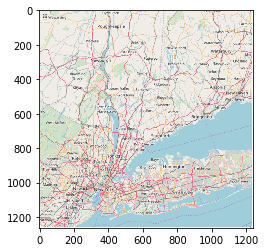

In [8]:
plt.imshow(nyc_map) 

In [9]:
nyc_map_zoom = plt.imread(r'C:\Users\zp&ff\Desktop\nyc_-74.3_-73.7_40.5_40.9.png')


In [10]:

# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)
 
    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

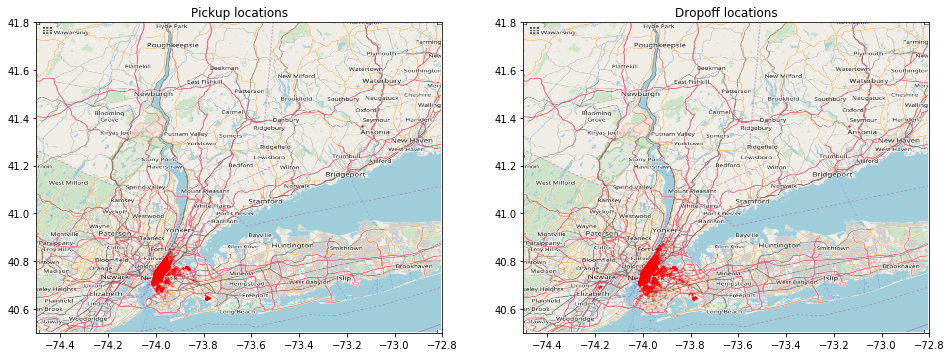

In [16]:
# plot training data on map
plot_on_map(data_raw, BB, nyc_map, s=1, alpha=0.3)
plt.savefig('fix.jpg')

In [18]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...
 
# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays
 
# To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
# This function needs an array with the (location) bins for counting the number of datapoints
# per bin.
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(data_raw.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(data_raw.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(data_raw.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(data_raw.dropoff_latitude, bins_lat)
 
# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

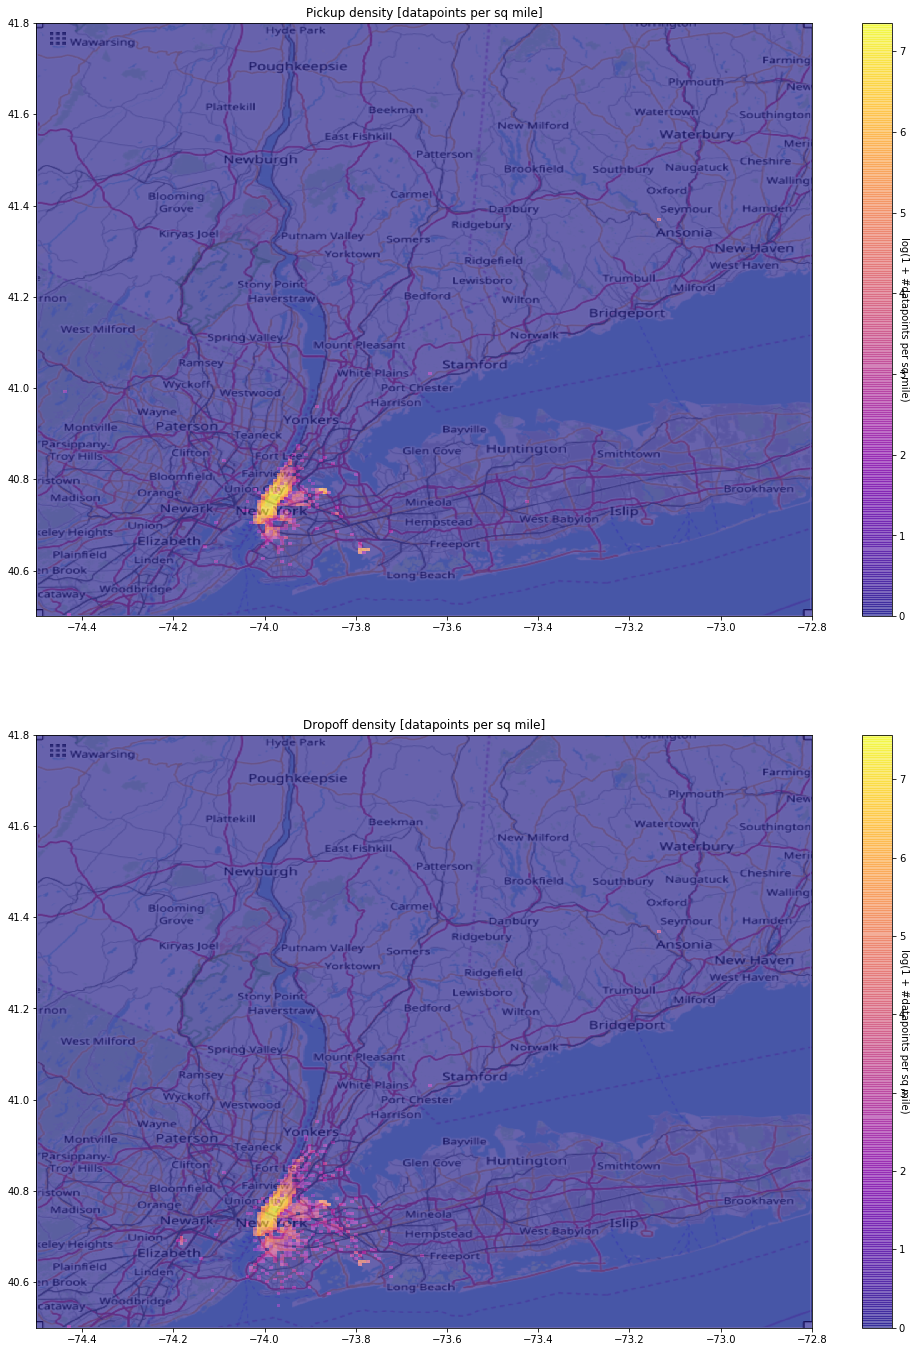

In [19]:

# Plot the density arrays
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(nyc_map, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[0].set_title('Pickup density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)
 
axs[1].imshow(nyc_map, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap='plasma')
axs[1].set_title('Dropoff density [datapoints per sq mile]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints per sq mile)', rotation=270)